## 1. Import bibliotek

In [1]:
# Ładuje rozszerzenie autoreload, które pozwala na automatyczne przeładowywanie modułów
%load_ext autoreload

# Ustawia tryb autoreload na 2 - wszystkie importowane moduły będą automatycznie przeładowywane przy każdej zmianie
%autoreload 2

from sklearn.linear_model import PoissonRegressor

from src.data.datareader import CleanedDataReader
from src.data.plots import freq_over_attribute_plot
from src.data.utils import create_group_id, drop_duplicates, dropna, prepare_target_and_weights
from src.features.sampling import split_data_by_group_and_stratify
from src.features.transformers import create_feature_pipeline, create_simple_feature_pipeline
from src.models.modeling import (
    train_and_evaluate_model,
    tune_glm_with_feature_pipeline,
    apply_best_params_and_train_model,
    tune_xgboost_model,
    save_model_with_pipeline,
    apply_best_params_and_train_xgboost_model
)
from src.models.scoring import print_summary

## 2. Wczytywanie danych

In [2]:
data_reader = CleanedDataReader(path='../../data/raw/claims_data.csv')
df = data_reader.get_enhanced_data(index_col=0)

Bad line:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93', '']
was converted to:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93']

Bad line:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', '', 'Regular', '68.0', 'R52']
was converted to:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', 'Regular', '68.0', 'R52']

Bad line:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52', '']
was converted to:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52']

Bad line:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', '', 'Regular', '6.0', 'R72']
was converted to:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', 'Regular', '6.0', 'R72']

Bad line:
['547534', '4138712.0', '1.0

## 3. Przygotowanie danych

Pierwsze, bardzo ogólne przetworzenie danych:
1. Usunięcie tych rekordów, które mają `NULL` w kolumnach `ClaimNb` lub `Exposure`,
2. Usunięcie duplikatów (jeżeli takie są) po kolumnie `IDPol`
3. Dodanie kolumny identyfikującej grupy polis z takimi samymi wartościami atrybutów - zadbamy o to, aby w momencie losowania zbiorów `train` i `test` polisy w ramach jednej grupy w całości znaleźli się w jednym ze zbiorów - ograniczymy w ten sposób ryzyko `Data Leakage`.
4. Ograniczenie wartości w kolumnach `ClaimNb` do maksymlanie 4 szkód oraz `Exposure` do maksymalnie 1.

In [3]:
df = dropna(df, subset=['ClaimNb', 'Exposure'])
df = drop_duplicates(df, subset=['IDpol'])
df = create_group_id(df)
df = df.assign(ClaimNb=lambda x: x.ClaimNb.clip(upper=4)).assign(Exposure=lambda x: x.Exposure.clip(upper=1))

### Przygotowanie Pipelines do przetwarzania danych

In [4]:
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
categorical_features = [col for col in df.select_dtypes(exclude='number').columns.tolist() if col not in numerical_features]

print(f"All columns: {df.columns.tolist()}")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Utworzenie pipeline'u z domyślnymi parametrami

pipeline_features = create_feature_pipeline(numerical_features, categorical_features)
pipeline_features.fit(df)


All columns: ['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'GroupID']
Numerical features: ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
Categorical features: ['Area', 'VehBrand', 'VehGas', 'Region']


Pipeline(steps=[('cap_veh_power',
                 CapTransformer(cap_value=13, column='VehPower',
                                else_behaviour='identity')),
                ('cap_veh_age',
                 CapTransformer(cap_value=21, column='VehAge',
                                else_behaviour='identity')),
                ('cap_driv_age',
                 CapTransformer(cap_value=90, column='DrivAge',
                                else_behaviour='identity')),
                ('cap_bonus_malus',
                 CapTransformer(cap_value=100, column='BonusMalus'...
                                                  ['VehAge']),
                                                 ('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['VehPower', 'VehAge',
                                                   'DrivAge', 'BonusMalus',
                                                   'Density']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Area', 'VehBrand', 'VehGas',
                                                   'Region'])],
                                   verbose_feature_names_out=False))])

### Atrybuty po zaaplikowaniu pipelinów

In [ ]:
pipeline_features[-1].get_feature_names_out()

array(['DrivAge_0.0', 'DrivAge_1.0', 'DrivAge_2.0', 'DrivAge_3.0',
       'DrivAge_4.0', 'DrivAge_5.0', 'DrivAge_6.0', 'DrivAge_7.0',
       'DrivAge_8.0', 'DrivAge_9.0', 'DrivAge_10.0', 'DrivAge_11.0',
       'DrivAge_12.0', 'DrivAge_13.0', 'DrivAge_14.0', 'DrivAge_15.0',
       'DrivAge_16.0', 'DrivAge_17.0', 'DrivAge_18.0', 'DrivAge_19.0',
       'VehAge_0.0', 'VehAge_1.0', 'VehAge_2.0', 'VehAge_3.0',
       'VehAge_4.0', 'VehAge_5.0', 'VehAge_6.0', 'VehAge_7.0', 'VehPower',
       'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Area_A', 'Area_B',
       'Area_C', 'Area_D', 'Area_E', 'Area_F', 'VehBrand_B1',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular',
       'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
       'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
       'Region_R41', 'Region_R42', 'Region_R4

### Prosty pipeline

In [6]:
simple_pipeline_features = create_simple_feature_pipeline(numerical_features, categorical_features)
simple_pipeline_features.fit(df)

Pipeline(steps=[('cap_veh_power',
                 CapTransformer(cap_value=13, column='VehPower',
                                else_behaviour='identity')),
                ('cap_veh_age',
                 CapTransformer(cap_value=21, column='VehAge',
                                else_behaviour='identity')),
                ('cap_driv_age',
                 CapTransformer(cap_value=90, column='DrivAge',
                                else_behaviour='identity')),
                ('cap_bonus_malus',
                 CapTransformer(cap_value=100, column='BonusMalus'...
                                   transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['VehPower', 'VehAge',
                                                   'DrivAge', 'BonusMalus',
                                                   'Density']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Area', 'VehBrand', 'VehGas',
                                                   'Region'])],
                                   verbose_feature_names_out=False))])

In [ ]:
simple_pipeline_features[-1].get_feature_names_out()

array(['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Area_A',
       'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'VehBrand_B1',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular',
       'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
       'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
       'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
       'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91',
       'Region_R93', 'Region_R94'], dtype=object)

## Podział zbioru na train i test
Podział jest dokonany tak aby:
1. Rekordy, które mają tę samą `GroupID` były w tym samym zbiorze (treningowy lub testowy) - `GroupShuffleSplit `
2. Zapewnić aby kolumna `ClaimNb` miała takie zbliżone proporcje w zbiorze train i test - `StratifiedShuffleSplit` 

In [8]:
train, test = split_data_by_group_and_stratify(df)

Train frequency: 10.049%
Test frequency: 10.109%
Train-test frequency difference: 0.060% (Relative difference: 0.594%)


# 4. Modelowanie

Rozkład Poissona jest naturalnym wyborem do modelowania liczby szkód ubezpieczeniowych, ponieważ dobrze opisuje rzadkie zdarzenia i przyjmuje tylko wartości nieujemne całkowite. Można oczywiście rozważan inne rozkłady (np. ujemny dwumianowy) testując rzeczywisty rozkład vs teoretyczny. Przyjąłem, że mają rozkład Poissona ważony. Dodatkowo każda obserwacja jest zważona ekspozycją.

W większości przypadków optymalizowałem Poisson Deviance i nastepnie analizowałem różnice do Poisson Deviance w DummyModel (model Poisson dla stałej - zważona ekspozycją średnia z liczby szkód).

### Pierwsze podejście do wytrenowania modelu - GLM z regularyzacją
1. Bias-Variance Tradeoff w GLM:
- Pomimo, iż GLM mają wypukłą funkcję straty i jedno globalne minimum, nadal mogą być zbyt złożone lub zbyt proste dla danych
    - Zbyt prosty (high bias) - gdy pomijamy ważne zmienne lub interakcje
    - Zbyt złożony (high variance) - gdy uwzględniamy zbyt wiele zmiennych lub nieistotne predyktory


2. Potencjalny overfitting w GLM (PoissonRegressor) może wynikać z następujących elementów:
- Mamy zbyt wiele zmiennych w stosunku do liczby obserwacji
- Zmienne są silnie skorelowane (multicollinearity)
- Model uwzględnia szum w danych treningowych


3. Metody przeciwdziałania overfittingowi w GLM:
- Regularyzacja (L1, L2)
- Selekcja zmiennych
- Cross-walidacja
- Analiza residuów i diagnostyka modelu


**W tym przypadku korzystam z regularyzacji L2 zaszytej w klasie PoissonRegressor. Analizując statystki modelu na zbiorze `train` i `test` oraz wykresach pokazujących prognozowaną `marginal frequency` wydaje się, że wytrenowany model dobrze uogólnia `pattern` z danych treningowych.**

W modelach GLM nie dodałem żadnych interakcji pomiędzy zmiennymi - traktuję go jako benchmark do bardziej złożonych modeli.

In [9]:
model_class = PoissonRegressor
params = {
    'alpha':0.001,
    'solver':'newton-cholesky'
}

model_glm_base, (summary_glm_base, X_train_pred_glm_base, X_test_pred_glm_base) = train_and_evaluate_model(train, test, pipeline_features, model_class, params)
save_model_with_pipeline(model_glm_base, '../../models/glm_based')
print_summary(summary_glm_base)

Model successfully saved to ../../models/glm_based.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 59.220
Poisson Deviance Test: 60.090
Improvement in Deviance Train: 4.991%
Improvement in Deviance Test: 4.794%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.050%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.019%


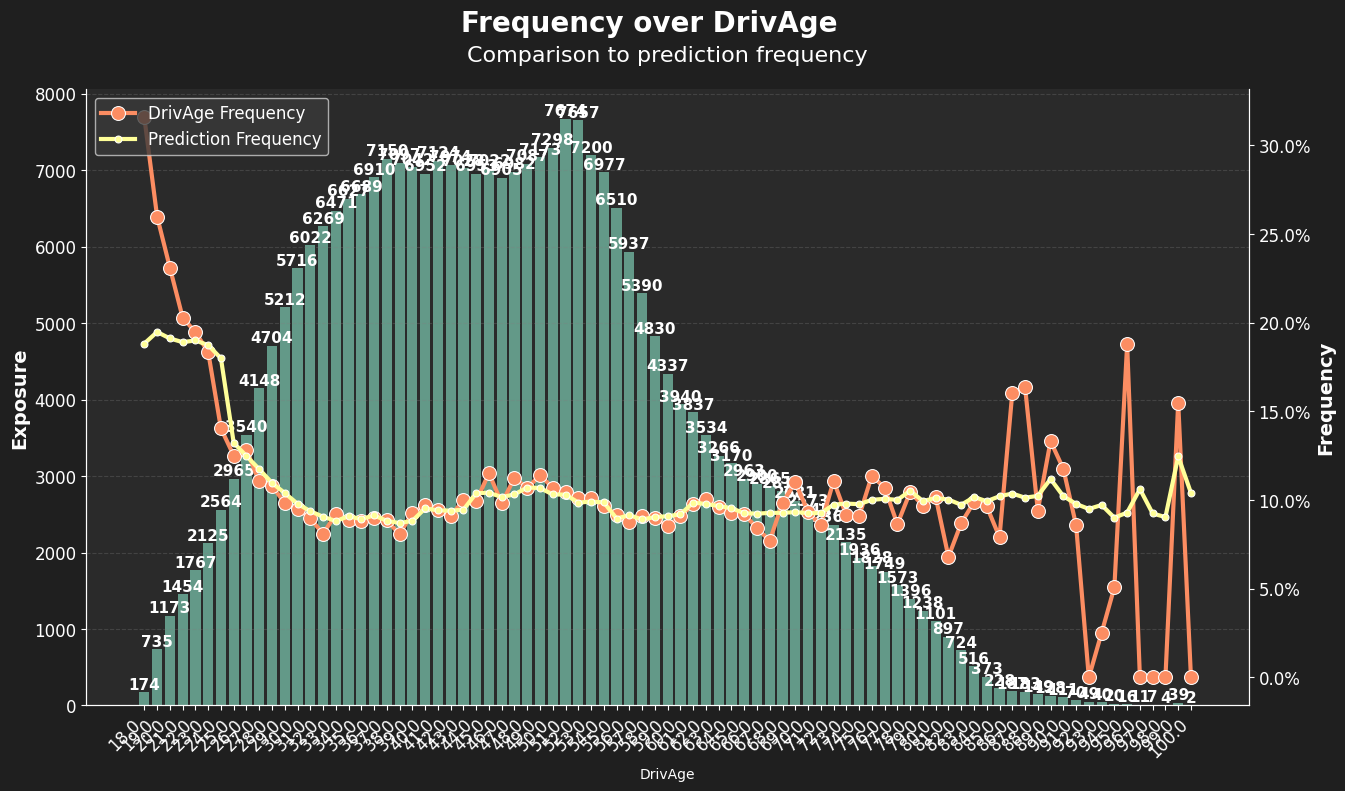

In [10]:
plot = freq_over_attribute_plot(X_train_pred_glm_base, attribute='DrivAge', compare_to='prediction')

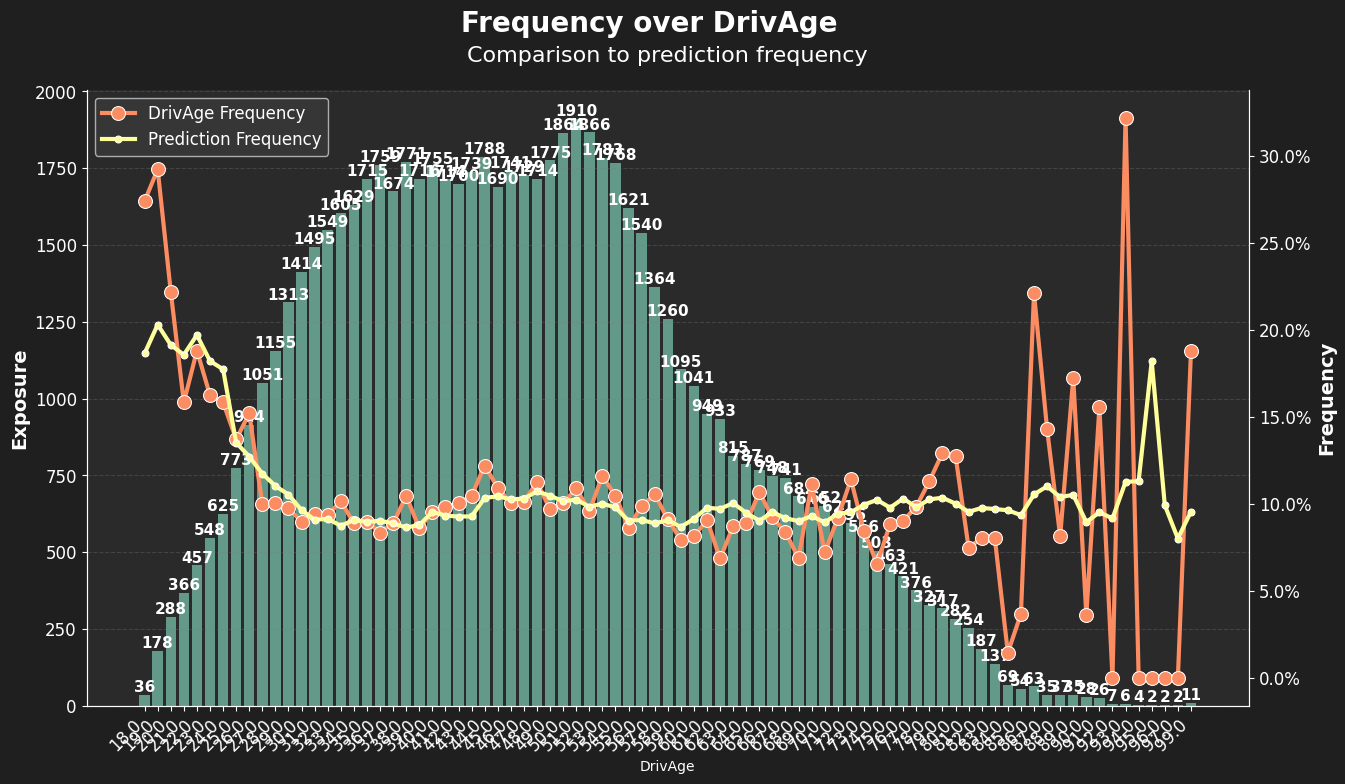

In [11]:
plot = freq_over_attribute_plot(X_test_pred_glm_base, attribute='DrivAge', compare_to='prediction')

# Model 2 - GLM z hipertuningiem preprocessu
Z wykorzystaniem `hyperopt` przeszukuję przestrzeń parametrów modelu PoissonRegressor (parametr regularyzacji L2 oraz maksymalną liczbę iteracji algorytmu) oraz przestrzeń konfiguracji pipelinu (jak ma podzielić zmienną `DrivAge` i `VehAge` oraz jak ma przyciąć wartości odstające w ramach kolumn `veh_power`, `veh_age`, `driv_age`, `bonus_malus`, `density`). Rezultatem poszukiwań jest najlepszy zestaw parametrów, który następnie wykorzystuję do trenowania finalnego modelu na całym zbiorze `train`.


In [12]:
N_trials = 200
y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
best = tune_glm_with_feature_pipeline(train, test, numerical_features, categorical_features, n_trials=N_trials)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  2%|▏         | 3/200 [00:23<25:41,  7.82s/trial, best loss: 0.5947991424835368]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  2%|▎         | 5/200 [00:37<24:12,  7.45s/trial, best loss: 0.5940168907279715]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  3%|▎         | 6/200 [00:44<23:33,  7.29s/trial, best loss: 0.5940168907279715]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  4%|▍         | 8/200 [00:58<22:45,  7.11s/trial, best loss: 0.5936231025639159]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  4%|▍         | 9/200 [01:05<22:48,  7.17s/trial, best loss: 0.5935694038663641]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  5%|▌         | 10/200 [01:13<23:21,  7.38s/trial, best loss: 0.5935694038663641]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  6%|▋         | 13/200 [01:35<22:19,  7.16s/trial, best loss: 0.5935694038663641]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  7%|▋         | 14/200 [01:42<22:39,  7.31s/trial, best loss: 0.5935694038663641]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  8%|▊         | 16/200 [01:57<22:14,  7.25s/trial, best loss: 0.5935125253347682]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

  8%|▊         | 17/200 [02:03<21:00,  6.89s/trial, best loss: 0.5935125253347682]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 11%|█         | 22/200 [02:37<20:09,  6.80s/trial, best loss: 0.5935125253347682]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 12%|█▎        | 25/200 [02:58<20:10,  6.92s/trial, best loss: 0.5935125253347682]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 13%|█▎        | 26/200 [03:06<20:24,  7.04s/trial, best loss: 0.5935125253347682]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 14%|█▎        | 27/200 [03:13<20:15,  7.03s/trial, best loss: 0.5935125253347682]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 14%|█▍        | 28/200 [03:20<20:08,  7.02s/trial, best loss: 0.5935125253347682]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 22%|██▎       | 45/200 [05:22<20:03,  7.77s/trial, best loss: 0.5935088049867584]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 26%|██▌       | 52/200 [06:11<17:27,  7.08s/trial, best loss: 0.5935088049867584]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 28%|██▊       | 56/200 [06:38<16:52,  7.03s/trial, best loss: 0.5935088049867584]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 28%|██▊       | 57/200 [06:46<16:57,  7.11s/trial, best loss: 0.5935088049867584]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 31%|███       | 62/200 [07:20<15:45,  6.85s/trial, best loss: 0.5935088049867584]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 37%|███▋      | 74/200 [08:43<14:44,  7.02s/trial, best loss: 0.5934851216261265]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 38%|███▊      | 76/200 [08:57<13:59,  6.77s/trial, best loss: 0.5934851216261265]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 39%|███▉      | 78/200 [09:11<14:00,  6.89s/trial, best loss: 0.5934851216261265]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 40%|███▉      | 79/200 [09:18<14:16,  7.08s/trial, best loss: 0.5934851216261265]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 42%|████▏     | 84/200 [09:53<13:47,  7.13s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 46%|████▋     | 93/200 [10:56<12:33,  7.04s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 47%|████▋     | 94/200 [11:02<12:02,  6.82s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 48%|████▊     | 95/200 [11:08<11:30,  6.58s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 48%|████▊     | 96/200 [11:15<11:34,  6.68s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 48%|████▊     | 97/200 [11:21<11:14,  6.55s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 49%|████▉     | 98/200 [11:28<11:26,  6.73s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 50%|████▉     | 99/200 [11:35<11:07,  6.61s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 50%|█████     | 100/200 [11:41<10:59,  6.60s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 50%|█████     | 101/200 [11:48<11:07,  6.74s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 51%|█████     | 102/200 [11:56<11:26,  7.00s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 52%|█████▏    | 103/200 [12:02<11:01,  6.82s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 52%|█████▏    | 104/200 [12:08<10:25,  6.52s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 53%|█████▎    | 106/200 [12:22<10:44,  6.86s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 54%|█████▎    | 107/200 [12:30<10:57,  7.07s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 54%|█████▍    | 108/200 [12:37<10:43,  7.00s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 55%|█████▍    | 109/200 [12:44<10:49,  7.14s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 55%|█████▌    | 110/200 [12:51<10:33,  7.04s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 56%|█████▌    | 111/200 [12:58<10:33,  7.12s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 56%|█████▋    | 113/200 [13:12<10:08,  7.00s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 57%|█████▋    | 114/200 [13:20<10:28,  7.30s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 58%|█████▊    | 117/200 [13:42<10:03,  7.27s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 60%|█████▉    | 119/200 [13:57<09:41,  7.18s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 61%|██████    | 122/200 [14:18<09:11,  7.07s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 62%|██████▏   | 123/200 [14:25<09:07,  7.11s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 62%|██████▎   | 125/200 [14:40<09:06,  7.28s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 64%|██████▍   | 128/200 [15:08<10:29,  8.74s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 66%|██████▌   | 131/200 [15:33<09:49,  8.54s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 66%|██████▌   | 132/200 [15:41<09:33,  8.43s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 67%|██████▋   | 134/200 [15:54<08:09,  7.42s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 68%|██████▊   | 135/200 [16:02<08:03,  7.43s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 70%|██████▉   | 139/200 [16:32<07:40,  7.55s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 70%|███████   | 140/200 [16:40<07:44,  7.75s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 71%|███████   | 142/200 [16:54<07:08,  7.39s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 72%|███████▏  | 143/200 [17:01<07:00,  7.38s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 72%|███████▏  | 144/200 [17:10<07:06,  7.62s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 72%|███████▎  | 145/200 [17:17<06:57,  7.59s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 73%|███████▎  | 146/200 [17:25<06:49,  7.57s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 74%|███████▎  | 147/200 [24:04<1:50:34, 125.17s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 74%|███████▍  | 148/200 [24:11<1:17:37, 89.57s/trial, best loss: 0.5934541655161985] 

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 74%|███████▍  | 149/200 [24:17<54:55, 64.61s/trial, best loss: 0.5934541655161985]  

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 75%|███████▌  | 150/200 [24:23<39:09, 46.99s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 76%|███████▌  | 151/200 [24:29<28:23, 34.76s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 76%|███████▌  | 152/200 [24:36<21:03, 26.33s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 76%|███████▋  | 153/200 [24:41<15:44, 20.09s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 77%|███████▋  | 154/200 [24:48<12:17, 16.02s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 78%|███████▊  | 155/200 [24:54<09:53, 13.19s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 78%|███████▊  | 156/200 [25:01<08:15, 11.26s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 78%|███████▊  | 157/200 [25:07<06:58,  9.74s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 79%|███████▉  | 158/200 [25:13<06:03,  8.65s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 80%|███████▉  | 159/200 [25:20<05:27,  8.00s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 80%|████████  | 160/200 [25:26<04:53,  7.33s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 80%|████████  | 161/200 [25:32<04:35,  7.07s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 81%|████████  | 162/200 [25:38<04:16,  6.76s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 82%|████████▏ | 163/200 [25:44<03:56,  6.38s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 82%|████████▏ | 164/200 [25:50<03:50,  6.39s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 83%|████████▎ | 166/200 [26:03<03:35,  6.33s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 84%|████████▎ | 167/200 [26:10<03:39,  6.64s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 84%|████████▍ | 168/200 [26:16<03:29,  6.55s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 84%|████████▍ | 169/200 [26:23<03:20,  6.47s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 86%|████████▌ | 171/200 [26:36<03:11,  6.59s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 86%|████████▌ | 172/200 [26:43<03:12,  6.88s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 86%|████████▋ | 173/200 [26:50<03:05,  6.86s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 87%|████████▋ | 174/200 [26:59<03:10,  7.32s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 89%|████████▉ | 178/200 [27:30<02:50,  7.77s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


 90%|█████████ | 181/200 [27:53<02:22,  7.51s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 92%|█████████▏| 184/200 [28:16<02:04,  7.78s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 93%|█████████▎| 186/200 [28:31<01:46,  7.57s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 94%|█████████▍| 189/200 [28:54<01:24,  7.70s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 96%|█████████▌| 191/200 [29:11<01:12,  8.10s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 96%|█████████▌| 192/200 [29:18<01:02,  7.82s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 96%|█████████▋| 193/200 [29:26<00:54,  7.74s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


 97%|█████████▋| 194/200 [29:34<00:46,  7.78s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 98%|█████████▊| 195/200 [29:41<00:38,  7.79s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 98%|█████████▊| 196/200 [29:49<00:30,  7.74s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

 99%|█████████▉| 198/200 [30:03<00:14,  7.39s/trial, best loss: 0.5934541655161985]

/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/imfilip/projects/freq_model/venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the numbe

100%|██████████| 200/200 [30:19<00:00,  9.10s/trial, best loss: 0.5934541655161985]


In [13]:
model_glm_tuned, (summary_glm_tuned, X_train_pred_glm_tuned, X_test_pred_glm_tuned), pipeline_features = (
    apply_best_params_and_train_model(
        best, 
        train, 
        test, 
        numerical_features, 
        categorical_features, 
        path_to_save=f'../../models/glm_{N_trials}t_tuned_pipeline'
    )
)

Model successfully saved to ../../models/glm_200t_tuned_pipeline.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 59.136
Poisson Deviance Test: 60.007
Improvement in Deviance Train: 5.126%
Improvement in Deviance Test: 4.925%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.132%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.098%


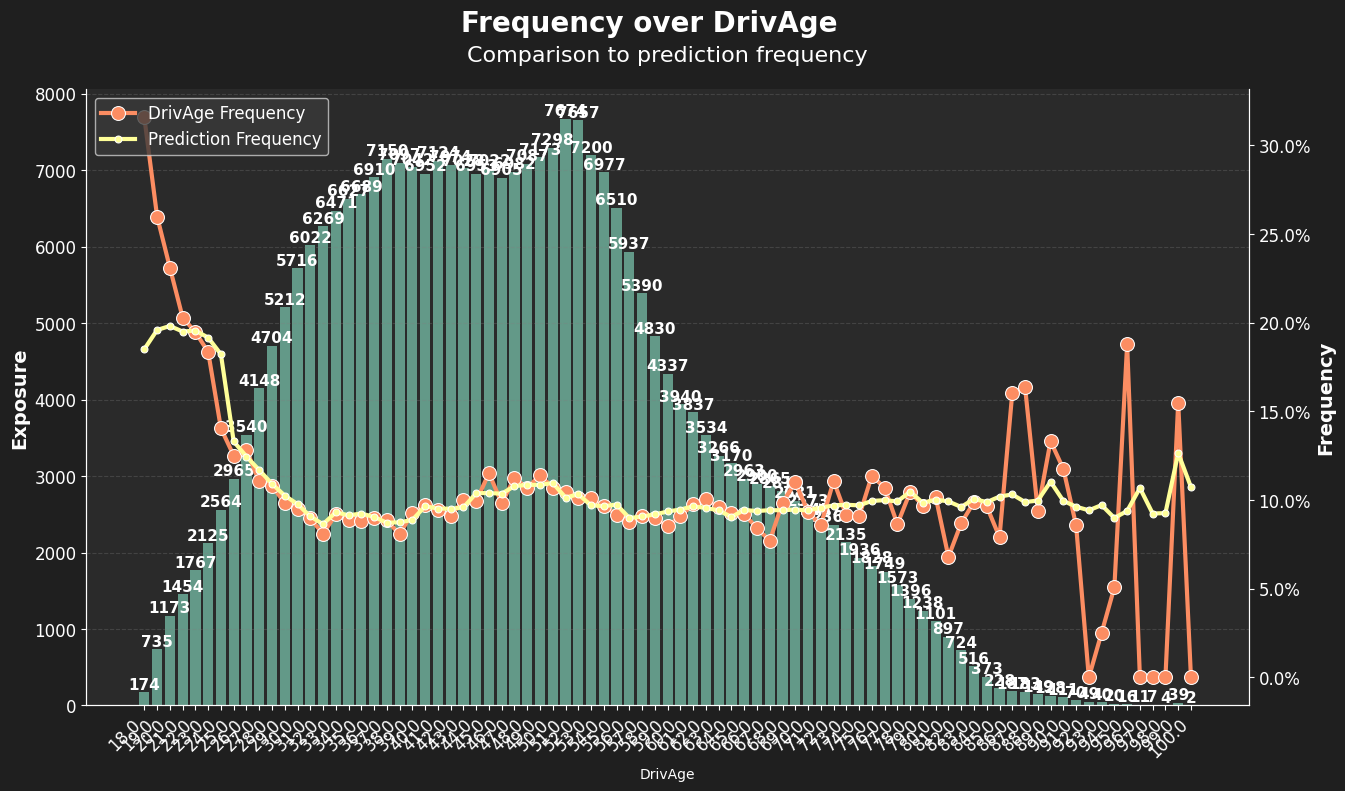

In [14]:
plot = freq_over_attribute_plot(X_train_pred_glm_tuned, attribute='DrivAge', compare_to='prediction')

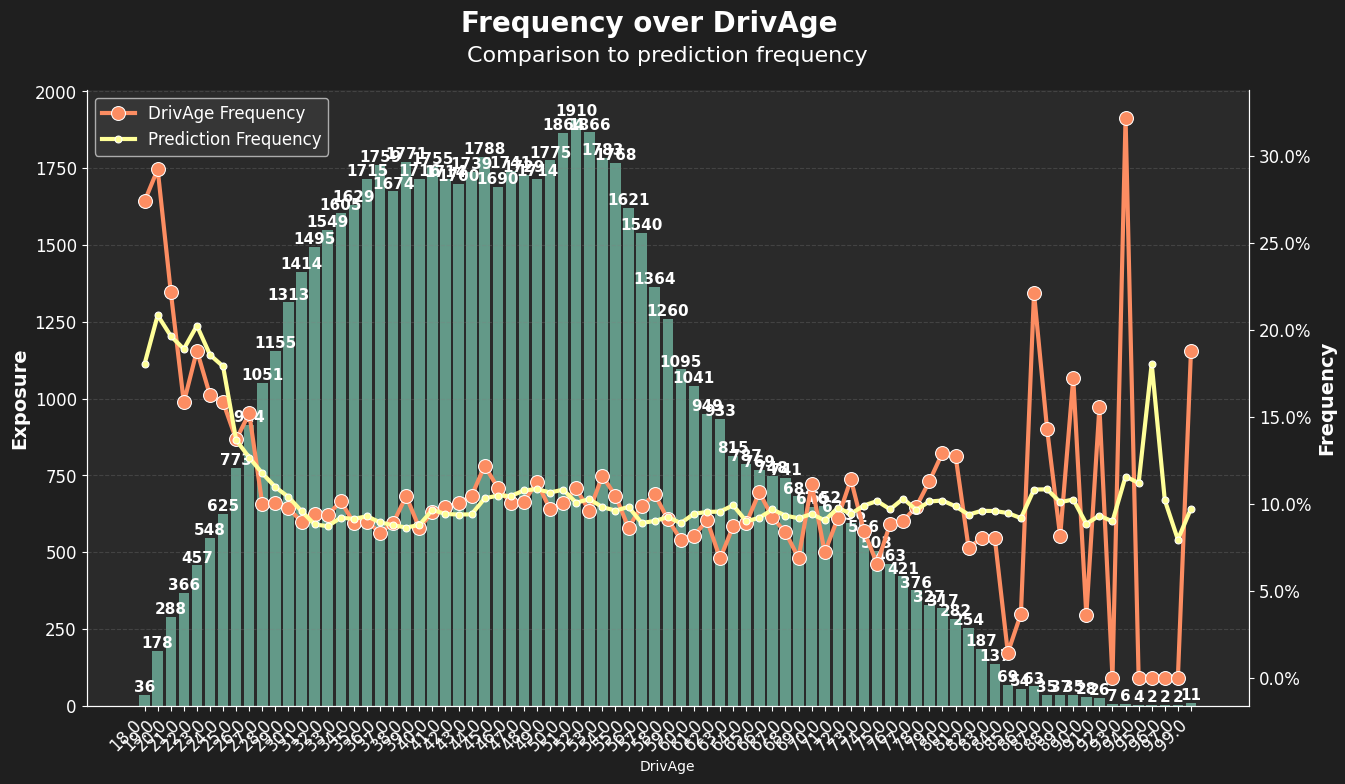

In [15]:
plot = freq_over_attribute_plot(X_test_pred_glm_tuned, attribute='DrivAge', compare_to='prediction')

## xgBoost

Problem `bias-variance trade-off` rozwiązuję przez `early_stopping`. Model przestaje się trenować dalej, jeżeli na zbiorach walidacyjnych w ramach walidacji krzyżowej metryka zaczyna się pogarszać.

### a. Korzystam z pipelinu z poprzedniego tuningu GLM

Z wykorzystaniem `hyperopt` przeszukuję przestrzeń parametrów modelu xgBoost (m.in. `learning_rate`, `max_depth`). Jako pipeline danych wykorzystuję pipeline, który wyszedł z trenowania poprzedniego modelu (GLM - PoissonRegressor). Rezultatem poszukiwań jest najlepszy zestaw parametrów, który następnie wykorzystuję do trenowania finalnego modelu na całym zbiorze `train`.

In [16]:
N_trials = 1
y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
best = tune_xgboost_model(train, test, pipeline_features, n_trials=N_trials)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

[0]	validation_0-poisson-nloglik:0.38053
[0]	validation_0-poisson-nloglik:0.37932
[0]	validation_0-poisson-nloglik:0.38370
[0]	validation_0-poisson-nloglik:0.37984
[0]	validation_0-poisson-nloglik:0.38277
[100]	validation_0-poisson-nloglik:0.35898
[100]	validation_0-poisson-nloglik:0.36091
[100]	validation_0-poisson-nloglik:0.36106
[100]	validation_0-poisson-nloglik:0.35907
[100]	validation_0-poisson-nloglik:0.36219
[195]	validation_0-poisson-nloglik:0.36082
[200]	validation_0-poisson-nloglik:0.36024
[200]	validation_0-poisson-nloglik:0.35854
[200]	validation_0-poisson-nloglik:0.35853
[200]	validation_0-poisson-nloglik:0.36172
[242]	validation_0-poisson-nloglik:0.35856
[300]	validation_0-poisson-nloglik:0.35980
[300]	validation_0-poisson-nloglik:0.35839
[300]	validation_0-poisson-nloglik:0.36145
[400]	validation_0-poisson-nloglik:0.35962
[400]	validation_0-poisson-nloglik:0.35824
[400]	validation_0-poisson-nloglik:0.36130
[424]	validation_0-poisson-nloglik:0.35827
[449]	validation_0-po

In [17]:
model_xgb_boost, (summary_xgboost, X_train_pred_xgboost, X_test_pred_xgboost) = (
    apply_best_params_and_train_xgboost_model(
        best, 
        train, 
        test, 
        pipeline_features, 
        f'../../models/xgboost_{N_trials}t_pipeline_best_from_glm_tuned'
    )
)


[0]	validation_0-poisson-nloglik:0.38370
[50]	validation_0-poisson-nloglik:0.36225
[100]	validation_0-poisson-nloglik:0.36118
[150]	validation_0-poisson-nloglik:0.36080
[200]	validation_0-poisson-nloglik:0.36055
[250]	validation_0-poisson-nloglik:0.36029
[300]	validation_0-poisson-nloglik:0.36016
[350]	validation_0-poisson-nloglik:0.35999
[400]	validation_0-poisson-nloglik:0.35983
[449]	validation_0-poisson-nloglik:0.35975
Model successfully saved to ../../models/xgboost_1t_pipeline_best_from_glm_tuned.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 56.469
Poisson Deviance Test: 58.109
Improvement in Deviance Train: 9.405%
Improvement in Deviance Test: 7.933%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.049%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.056%


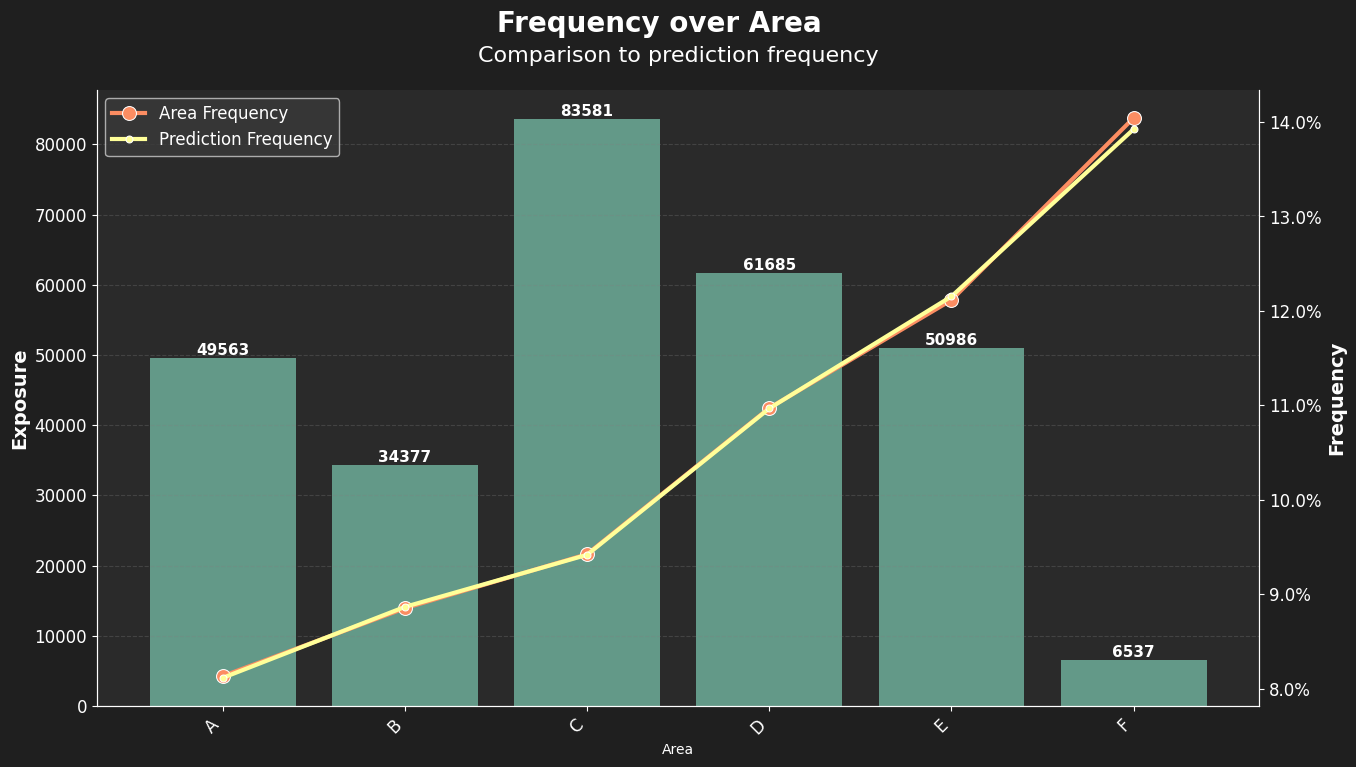

In [18]:
plot = freq_over_attribute_plot(X_train_pred_xgboost, attribute='Area', compare_to='prediction')

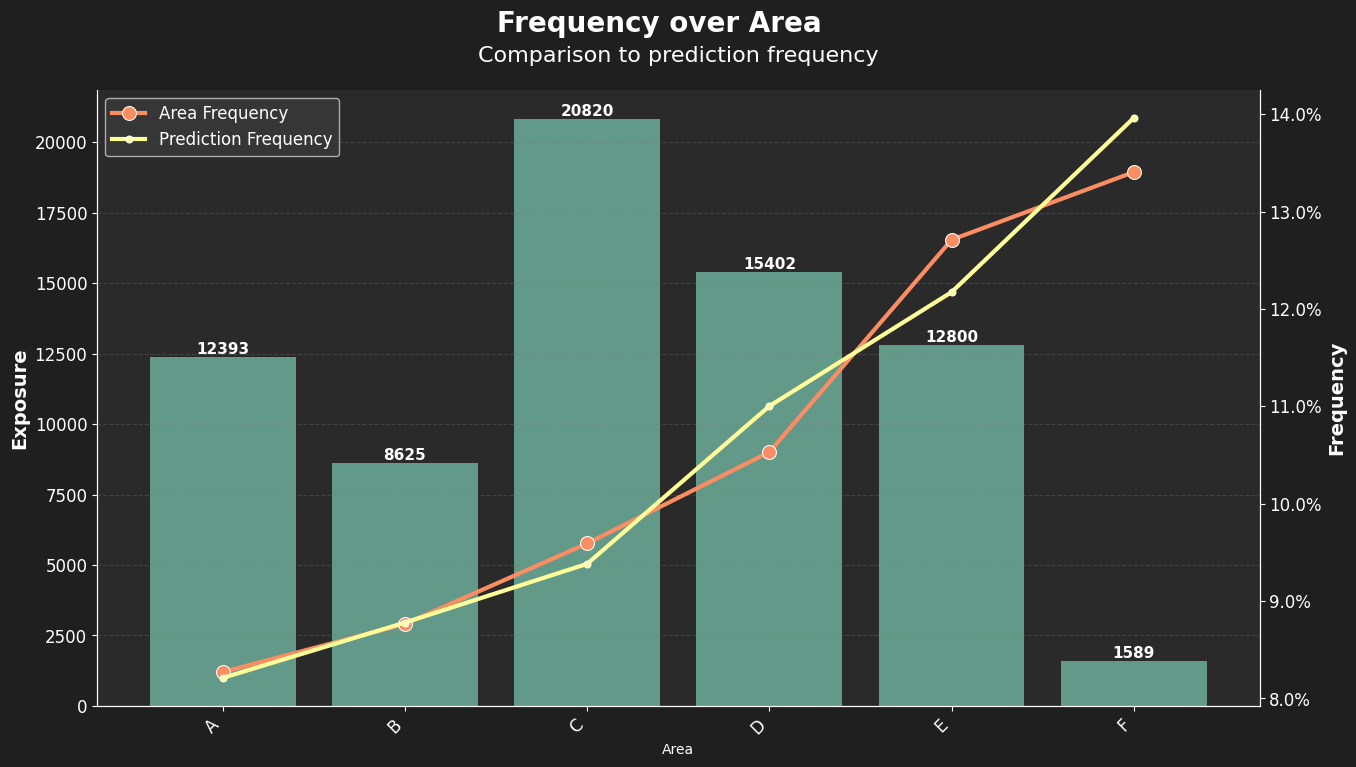

In [19]:
plot = freq_over_attribute_plot(X_test_pred_xgboost, attribute='Area', compare_to='prediction')

### b. Korzystam z prostego pipelinu (tylko imputowanie, skalowanie i dekodowanie zmiennych)

In [20]:
N_trials = 1
y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
best = tune_xgboost_model(train, test, simple_pipeline_features, n_trials=N_trials)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

[0]	validation_0-poisson-nloglik:0.38049
[0]	validation_0-poisson-nloglik:0.38360
[0]	validation_0-poisson-nloglik:0.37973
[0]	validation_0-poisson-nloglik:0.37921
[0]	validation_0-poisson-nloglik:0.38270
[66]	validation_0-poisson-nloglik:0.36805
[66]	validation_0-poisson-nloglik:0.37063
[100]	validation_0-poisson-nloglik:0.36132
[100]	validation_0-poisson-nloglik:0.35807
[100]	validation_0-poisson-nloglik:0.36140
[192]	validation_0-poisson-nloglik:0.36141
[200]	validation_0-poisson-nloglik:0.36060
[200]	validation_0-poisson-nloglik:0.35754
[245]	validation_0-poisson-nloglik:0.35752
[300]	validation_0-poisson-nloglik:0.36019
[400]	validation_0-poisson-nloglik:0.35999
[449]	validation_0-poisson-nloglik:0.35993
100%|██████████| 1/1 [01:01<00:00, 61.93s/trial, best loss: 0.5782149374848942]


In [21]:
model_xgb_boost, (summary_xgboost, X_train_pred_xgboost, X_test_pred_xgboost) = (
    apply_best_params_and_train_xgboost_model(
        best, 
        train, 
        test, 
        simple_pipeline_features, 
        f'../../models/xgboost_{N_trials}t_simple_pipeline'
    )
)

[0]	validation_0-poisson-nloglik:0.38365
[50]	validation_0-poisson-nloglik:0.36337
[100]	validation_0-poisson-nloglik:0.36247
[150]	validation_0-poisson-nloglik:0.36214
[183]	validation_0-poisson-nloglik:0.36213
Model successfully saved to ../../models/xgboost_1t_simple_pipeline.joblib
Poisson Deviance Dummy Train: 62.330
Poisson Deviance Dummy Test: 63.116
Poisson Deviance Train: 57.098
Poisson Deviance Test: 58.293
Improvement in Deviance Train: 8.395%
Improvement in Deviance Test: 7.642%
Frequency Train Actual: 10.049%
Frequency Train Model: 10.049%
Frequency Test Actual: 10.109%
Frequency Test Model: 10.046%


### c. Hipertuning hipertuningu

In [22]:
n_trials_list = [1, 5, 10, 20, 30]
feature_pipelines = [simple_pipeline_features, pipeline_features]

for feature_pipeline in feature_pipelines:
    for N_trials in n_trials_list:
        y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)
        best = tune_xgboost_model(train, test, feature_pipeline, n_trials=N_trials)
        model_xgb_boost, (summary_xgboost, X_train_pred_xgboost, X_test_pred_xgboost) = (
        apply_best_params_and_train_xgboost_model(
            best, 
            train, 
            test, 
            feature_pipeline, 
            f'../../models/xgboost_{N_trials}t_{"simple_pipeline" if feature_pipeline == simple_pipeline_features else "pipeline"}'
            )
        )
    

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

[0]	validation_0-poisson-nloglik:0.38049
[0]	validation_0-poisson-nloglik:0.38360
[0]	validation_0-poisson-nloglik:0.37973
[0]	validation_0-poisson-nloglik:0.37921
[0]	validation_0-poisson-nloglik:0.38270
[66]	validation_0-poisson-nloglik:0.36871
[65]	validation_0-poisson-nloglik:0.37062
[100]	validation_0-poisson-nloglik:0.36211
[100]	validation_0-poisson-nloglik:0.36104
[100]	validation_0-poisson-nloglik:0.35897
[200]	validation_0-poisson-nloglik:0.36162
[200]	validation_0-poisson-nloglik:0.35842
[200]	validation_0-poisson-nloglik:0.36084
[210]	validation_0-poisson-nloglik:0.36091
[300]	validation_0-poisson-nloglik:0.36134
[296]	validation_0-poisson-nloglik:0.35819
[400]	validation_0-poisson-nloglik:0.36116
[449]	validation_0-poisson-nloglik:0.36115
100%|██████████| 1/1 [01:03<00:00, 63.62s/trial, best loss: 0.5780834906453395]
[0]	validation_0-poisson-nloglik:0.38364
[50]	validation_0-poisson-nloglik:0.36238
[100]	validation_0-poisson-nloglik:0.36110
[150]	validation_0-poisson-nlogl